In [23]:
__author__='莫叹'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [22]:
import os 
os.chdir('G:\数据分析资料\餐饮店铺选址分析')
df1=pd.read_excel('上海餐饮数据.xlsx')
print(len(df1))

96398


In [4]:
#去除空值
df1.dropna(inplace=True)
#print('去除缺失值后剩余数据量：',len(df1))
print(len(df1[df1['口味']>0]))
print((len(df1[df1['环境']>0])))
print((len(df1[df1['服务']>0])))

78583
78583
78583


In [5]:
#口味、环境、服务评分不大于0的数据量相同，粗略看一下数据，可以判定，三者要么同时为0，要么同时都是正确数据
data=df1[(df1['服务']>0)&(df1['人均消费']>0)]
data_kouwei=df1[(df1['口味']>0)&(df1['人均消费']>0)]
print(len(data),len(data_kouwei))
# # 筛选数据，清除空值、为0的数据

54886 54886


In [6]:
#口味：环境：服务=5:3:2权重
data['性价比']=(data['口味']*0.5+data['环境']*0.3+data['服务']*0.2)/data['人均消费']
data.head()

,类别,行政区,点评数,口味,环境,服务,人均消费,城市,Lng,Lat,性价比
0,烧烤,浦东新区,176,8.0,8.6,7.9,124,上海市,121.967860,30.884477,0.065806
2,粤菜,浦东新区,141,6.7,7.2,6.6,141,上海市,121.933142,30.893224,0.048440
3,海鲜,浦东新区,76,7.2,7.2,7.3,148,上海市,121.926062,30.899868,0.048784
4,烧烤,浦东新区,600,7.2,7.6,7.0,143,上海市,121.925877,30.901100,0.050909
5,本菜,嘉定区,69,8.2,8.9,8.4,66,上海市,121.925866,30.906384,0.128030


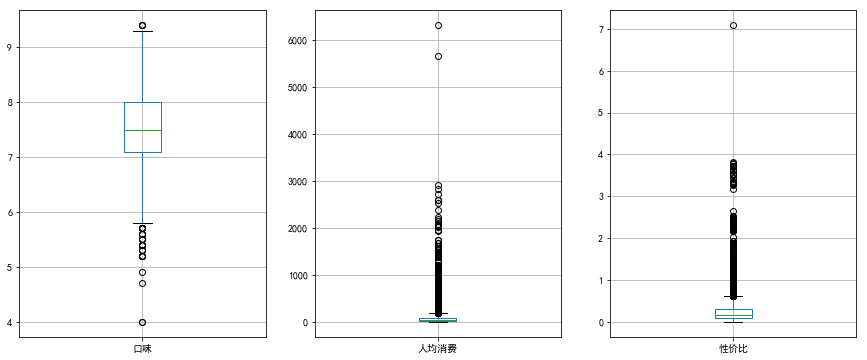

In [7]:
#制作箱型图查看异常值
# def boxplot(data):
#     fig,axes=plt.subplots(1,3,figsize=(15,6))
#     data.boxplot(column=['口味'],ax=axes[0])
#     data.boxplot(column=['人均消费'],ax=axes[1])
#     data.boxplot(column=['性价比'],ax=axes[2])
# boxplot(data)
def boxplot(data,*args):
    fig,axes=plt.subplots(1,len(args),figsize=(15,6))
    for i in range(0,len(args)):     
        data.boxplot(column=[args[i]],ax=axes[i])
boxplot(data,'口味','人均消费','性价比')


In [8]:
#去除异常值
#分情况去除异常值，口味评分的数据比较集中，去除温和异常值，其他的诸如性价比，人均消费可能出现少量极高或者极低，这里就去除极度异常值
def remove_outliers(data,col):
    Q1=data[col].quantile(q=0.25)#下四分位数
    Q3=data[col].quantile(q=0.75)#上四分位
    IQR=Q3-Q1#四分位数全距
    if col=='口味':
        down_limit=Q1-1.5*IQR#下温和异常值边界
        up_limit=Q3+1.5*IQR#上温和异常值边界
    else:
        down_limit=Q1-3*IQR#下异常异常值边界
        up_limit=Q3+3*IQR#上异常异常值边界
    print(col,'下上四分位，下上异常边界值分别为：',Q1,Q3,down_limit,up_limit)
 #   clean_data=data[(data[col]>down_outlier)&(data[col]<up_outlier)]
    clean_data=data[(data[col] > down_limit)&(data[col] < up_limit)]
    return clean_data

In [9]:
data_clean=remove_outliers(data,'口味')
print('清洗口味前的数据量:',len(data),'清洗口味后的数据数量:',len(data_clean))

口味 下上四分位，下上异常边界值分别为： 7.1 8.0 5.749999999999999 9.350000000000001
清洗口味前的数据量: 54886 清洗口味后的数据数量: 54851


In [10]:
data_clean=remove_outliers(data_clean,'人均消费')
print('清洗人均消费后的数据数量:',len(data_clean))

人均消费 下上四分位，下上异常边界值分别为： 24.0 87.0 -165.0 276.0
清洗人均消费后的数据数量: 53373


In [11]:
data_clean=remove_outliers(data_clean,'性价比')
print('清洗性价比后的数据数量:',len(data_clean))

性价比 下上四分位，下上异常边界值分别为： 0.0925974025974026 0.3090909090909091 -0.5568831168831169 0.9585714285714285
清洗性价比后的数据数量: 53059


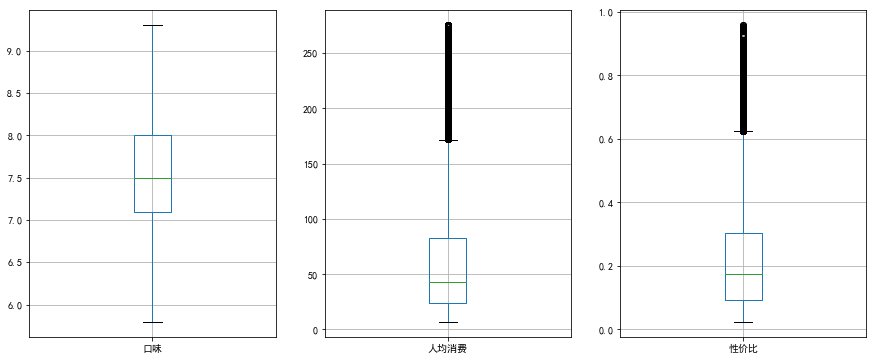

In [12]:
boxplot(data_clean,'口味','人均消费','性价比')

In [13]:
#数据分组
#分组，去除字符型数据
def data_groupby(data,col):
  #  data_group=data[['类别','口味','环境','服务','人均消费','性价比','点评数']]
    data_group=data[['类别','口味','人均消费','性价比']]
    data_group=data_group.groupby(col).mean()
    return data_group
data_group=data_groupby(data_clean,'类别')
data_group.head()
#data_clean[['类别','口味','环境','服务','人均消费','性价比','点评数']]


,口味,人均消费,性价比
类别,,,
亚菜,7.872511,94.714286,0.105758
助餐,7.364413,125.562278,0.083003
北菜,7.355779,50.541457,0.188671
午茶,7.500000,150.000000,0.052467
南菜,8.006780,91.389831,0.108644


In [14]:
#数据归一化
def data_norm(data,*args):
    for i in range(0,len(args)):
        col_name=args[i]+'_norm'
        data[col_name]=(data[args[i]]-data[args[i]].min())/(data[args[i]].max()-data[args[i]].min())
    return data
data_deal=data_norm(data_group,'口味','人均消费','性价比')
columns=['口味','口味_norm','人均消费','人均消费_norm','性价比','性价比_norm']#改变列名顺序

data_deal=data_deal[columns]
data_deal.sort_values(by='性价比_norm',inplace = True, ascending=False)#大部分中国人喜欢划算，我们以性价比排序
#data_deal.head()
data_deal.tail()

,口味,口味_norm,人均消费,人均消费_norm,性价比,性价比_norm
类别,,,,,,
龙虾,7.504834,0.277893,96.593656,0.567657,0.095752,0.141216
海鲜,7.659129,0.499864,113.282158,0.702757,0.093478,0.133798
助餐,7.364413,0.075881,125.562278,0.802168,0.083003,0.099621
蟹宴,7.552525,0.346503,120.919192,0.764581,0.079057,0.086749
午茶,7.500000,0.270939,150.000000,1.000000,0.052467,0.000000


In [15]:
from bokeh.plotting import figure,show,output_file
from bokeh.models import ColumnDataSource
from bokeh.models.annotations import BoxAnnotation
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
#from copy import deepcopy
import copy
output_file('bokeh_graph1.html')

#制作散点图
#data_deal['size'] = data_deal['口味_norm'] * 40  # 添加size字段作为点的大小
data_deal.index.name='type'
data_deal.columns=['kw','kw_norm','price','price_norm','xjb','xjb_norm']
data_deal['size'] = data_deal['kw_norm'] * 40  # 添加size字段作为点的大小
data_deal_2=copy.deepcopy(data_deal)
data_deal_3=copy.deepcopy(data_deal)

source=ColumnDataSource(data_deal)

hover = HoverTool(tooltips=[("餐饮类型", "@type"),
                            ("人均消费", "@price"),
                            ("性价比得分", "@xjb_norm"),
                            ("口味得分", "@kw_norm")
                           ])  # 设置标签显示内容
result = figure(plot_width=800, plot_height=250,
                title="餐饮类型得分情况" ,
                x_axis_label = '人均消费', y_axis_label = '性价比得分', 
                tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair']) 
# 构建绘图空间
result.circle(x='price',y='xjb_norm',source=source,
             line_color='red',line_dash=[6,4],fill_alpha = 0.6,
        size = 'size')

# # # 组合图表

bokeh.models.renderers.GlyphRenderer(
    id='d8b6fea8-278f-46a4-b931-e42cc3651732',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='1ccc7dea-6a10-43db-b68e-c59e8143f6ef',
        callback=None,
        data={'kw': {'__ndarray__': '+YokOrcYHkD9tzAzAnMdQFYgjLRjBR5A0zVd0zW9HUASsZXvNSofQMFY8oslPx1ArLgktTKIHkCddnFNUWwdQJwzgKY5AyBAEe4DKWtwHUAOmLBAz3QeQJ4O6qAOKh5A2KNwPQoXH0DM6fuF6WAeQHS2/QLB+R1AGXdSL3MTH0AjffavSD8fQI4KQc4QTR5AWlmP4CfnHUAIsayfeAMgQDRcIHpzfR9AlflIbJiPH0C9qaZXoLkfQJvgTCnzBB5AmvKinfKiHkAhnsyhKHUdQJI9By7JNR5AAAAAAAAAHkA=',
          'dtype': 'float64',
          'shape': (28,)},
         'kw_norm': {'__ndarray__': 'GOV8UviP0z8R25WM/6ayP0YNsQ0f09E/lzk/Vmyrxj9LTN3bnRPmPwAAAAAAAAAATSTBhw2W3T9xXpO/8j6wPzLSZH1W+u8/Bpuqk4i4sT8WK3OExdfbP6K+q8EhH9U/iC0YlPs25T/qrFzexg3aP7pDvfVLx9A/TEUBP6oN5T8HNoyfJQbnP+bdJLjzRNg/XXH22Wk2zj8AAAAAAADwP2H8Fquf0ek/iIgC+3Gi6j8pA9UILYbsPwvgAIkAydE//dCOlsX93z/FUT+U9myzP4NnaQAaLdY/Rf3FNxFX0T8=',
          'dtype': 'float64',
          'shape': (28,)},
         'price': {'__ndarray__': 'n6/H7iLcPkDGLEx04Hg6QCivobyG8jtA6qEe6qG+TkCmuQv+Ks5NQBERERERIUdA+V5NfZiHRkAatOx4TkVJQAQCgUAg0FFAwcmTckpPTUAZkI6lTEJQQNu2bdu21VBAAAAAAADIUUCkqwSwGWhSQBGv85n7lk9AHhYTRYz1UkDULwuxNHFXQAwYjPoA31ZAy+QJiM63VUBoOKn78thWQNu2bdu2rVdAKEGFo1vWW0DWnmiTI59YQPoXA3T+JVhA3w4S3w5SXECAaxpb/GNfQFDrVwrUOl5AAAAAAADAYkA=',
          'dtype': 'float64',
          'shape': (28,)},
         'price_norm': {'__ndarray__': 'y6AVKLQvoj8AAAAAAAAAAB8xHnAmdYg/OPWWa3ck0j/CnAPVSyvRP7uYX1WjgMQ/6Pl8Y5VCwz+6cCWB0PDIP1Ofx7FTM9c/dPhcXtOn0D+dv1483vrTP+vVWDBfLNU/o4yEkHwi1z/hVh+dR27YP0mrVUemBNM/V/jVsmqT2T+AdmJ16m7hPynqg7hr1+A/pQOkrBJL3z/02gGcJdHgP2hkPm2dreE/HMiJgc385T9FJM+1x6fiP2f9i8s/KuI/pBZbNvt85j+Bw7POXKvpPxpl22Jyd+g/AAAAAAAA8D8=',
          'dtype': 'float64',
          'shape': (28,)},
         'size': {'__ndarray__': 'Xh4cZ/ZzKEDVUbtvv1AHQJhQHdHmRyZA/QfPa0dWHEBen9RShZg7QAAAAAAAAAAAsLbYdMh9MkANNnhvr04EQF8DXw52/ENAyEGVuKomBkDu+sdy22YxQEquFjLqZipA6jgeebqEOkAS7PlKnEgwQKiULPMe+SRAn5bBzhRROkCJQ28Hr8c8QGAVLqYwVi5A2gY6KALiIkAAAAAAAABEQL1d7soDI0BAVZXhPIelQED6IYUl3NNBQA4YQatAOyZAnkIZfpv+M0A2Jk85NEgIQGTBg4BguCtAlny3hdWsJUA=',
          'dtype': 'float64',
          'shape': (28,)},
         'type': ['甜点',
          '快餐',
          '面馆',
          '美食',
          '疆菜',
          '常菜',
          '啡厅',
          '北菜',
          '素菜',
          '湘菜',
          '湾菜',
          '西菜',
          '州菜',
          '烧烤',
          '川菜',
          '料理',
          '西餐',
          '粤菜',
          '浙菜',
          '南菜',
          '亚菜',
          '本菜',
          '火锅',
          '龙虾',
          '海鲜',
          '助餐',
          '蟹宴',
          '午茶'],
         'xjb': {'__ndarray__': 'dfn7b6D51j/s38EfvbjVP0LuulM0ydM/AnEsXsTvyj/mmN4nlS3KP8GXG92VH8o/myVr4dK2yT+RBf9QXCbIPzHvQU3kicU/MROivm+txD/AEFu7swnEP70mOOYqysM/0zbghtrZwj9iVnjCgZvCP4jzJjy3OsI/U3tF1S4+wT/n0DFn/t/AP8m3HIyvCb8/B2DDXoWVvT+3fWp0GtC7P67FRjT0Ers/ybG75/zhuj+yCWoE7Zy4Px5Farozg7g/PrUhhDPutz85i0Pjpj+1P9O6oPcQPbQ/gUvtMuncqj8=',
          'dtype': 'float64',
          'shape': (28,)},
         'xjb_norm': {'__ndarray__': 'AAAAAAAA8D+CPG/Jj/TtP0iUo6M8zOo/omafgQh+4D/QbJQqT7/fP41ZxAh6qN8/KCEEapb93j+Xsqs9WHDcP5mR+RDtLdg/I7OOtlDG1j/J0iqKOrvVPza0dQuXU9U/hdbU4JXL0z9UGlxh4mXTPwsQlzH/x9I/N7ghhw8s0T8qESDjapLQP2R6J/RGuMw/tihP9TFZyj+DLitqknXHP4q3ciUHQcY/R6vVVSfxxT+8I+SCUD3CPxeeXndaE8I/98yC7EwgwT+XvCrwxoC5Pyr9XWYoNbY/AAAAAAAAAAA=',
          'dtype': 'float64',
          'shape': (28,)}},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='05aaf11a-7a89-49ec-9701-84553c1832cf',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='127e6084-8efc-4cf1-bdd3-f4f8f15db8a4',
    

In [16]:
#绘制柱状图
data_deal_2.sort_values(by='kw_norm',inplace=True,ascending=False)
data_type_2=data_deal_2.index.tolist()
source2=ColumnDataSource(data_deal_2)
kw=figure(plot_width=800,plot_height=250,title='口味得分',x_range=data_type_2,
          tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
kw.vbar(x='type',top='kw_norm',source=source2,width=0.9,alpha=0.8,color='black')



bokeh.models.renderers.GlyphRenderer(
    id='70a7920a-ef3e-46d3-a6b0-07ed01e237bf',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='fcf60168-b1dd-401d-aef0-cfbea7aa898c',
        callback=None,
        data={'kw': {'__ndarray__': 'CLGsn3gDIECcM4CmOQMgQL2ppleguR9AlflIbJiPH0A0XCB6c30fQCN99q9IPx9AErGV7zUqH0DYo3A9ChcfQBl3Ui9zEx9AmvKinfKiHkCsuCS1MogeQA6YsEDPdB5AzOn7helgHkCOCkHOEE0eQJI9By7JNR5Ang7qoA4qHkD5iiQ6txgeQFYgjLRjBR5Am+BMKfMEHkAAAAAAAAAeQHS2/QLB+R1AWlmP4CfnHUDTNV3TNb0dQCGezKEodR1A/bcwMwJzHUAR7gMpa3AdQJ12cU1RbB1AwVjyiyU/HUA=',
          'dtype': 'float64',
          'shape': (28,)},
         'kw_norm': {'__ndarray__': 'AAAAAAAA8D8y0mR9VvrvPykD1Qgthuw/iIgC+3Gi6j9h/Barn9HpPwc2jJ8lBuc/S0zd250T5j+ILRiU+zblP0xFAT+qDeU//dCOlsX93z9NJMGHDZbdPxYrc4TF19s/6qxc3sYN2j/m3SS480TYP4NnaQAaLdY/or6rwSEf1T8Y5XxS+I/TP0YNsQ0f09E/C+AAiQDJ0T9F/cU3EVfRP7pDvfVLx9A/XXH22Wk2zj+XOT9WbKvGP8VRP5T2bLM/EduVjP+msj8Gm6qTiLixP3Fek7/yPrA/AAAAAAAAAAA=',
          'dtype': 'float64',
          'shape': (28,)},
         'price': {'__ndarray__': 'aDip+/LYVkAEAoFAINBRQNaeaJMjn1hAKEGFo1vWW0Dbtm3btq1XQNQvC7E0cVdAprkL/irOTUAAAAAAAMhRQB4WE0WM9VJA3w4S3w5SXED5Xk19mIdGQBmQjqVMQlBApKsEsBloUkAMGIz6AN9WQFDrVwrUOl5A27Zt27bVUECfr8fuItw+QCivobyG8jtA+hcDdP4lWEAAAAAAAMBiQBGv85n7lk9Ay+QJiM63VUDqoR7qob5OQIBrGlv8Y19AxixMdOB4OkDByZNySk9NQBq07HhORUlAEREREREhR0A=',
          'dtype': 'float64',
          'shape': (28,)},
         'price_norm': {'__ndarray__': '9NoBnCXR4D9Tn8exUzPXP0Ukz7XHp+I/HMiJgc385T9oZD5tna3hP4B2YnXqbuE/wpwD1Usr0T+jjISQfCLXP1f41bJqk9k/pBZbNvt85j/o+XxjlULDP52/Xjze+tM/4VYfnUdu2D8p6oO4a9fgPxpl22Jyd+g/69VYMF8s1T/LoBUotC+iPx8xHnAmdYg/Z/2Lyz8q4j8AAAAAAADwP0mrVUemBNM/pQOkrBJL3z849ZZrdyTSP4HDs85cq+k/AAAAAAAAAAB0+Fxe06fQP7pwJYHQ8Mg/u5hfVaOAxD8=',
          'dtype': 'float64',
          'shape': (28,)},
         'size': {'__ndarray__': 'AAAAAAAAREBfA18OdvxDQPohhSXc00FAVZXhPIelQEC9Xe7KAyNAQIlDbwevxzxAXp/UUoWYO0DqOB55uoQ6QJ+Wwc4UUTpAnkIZfpv+M0Cwtth0yH0yQO76x3LbZjFAEuz5SpxIMEBgFS6mMFYuQGTBg4BguCtASq4WMupmKkBeHhxn9nMoQJhQHdHmRyZADhhBq0A7JkCWfLeF1awlQKiULPMe+SRA2gY6KALiIkD9B89rR1YcQDYmTzk0SAhA1VG7b79QB0DIQZW4qiYGQA02eG+vTgRAAAAAAAAAAAA=',
          'dtype': 'float64',
          'shape': (28,)},
         'type': ['南菜',
          '素菜',
          '火锅',
          '本菜',
          '亚菜',
          '西餐',
          '疆菜',
          '州菜',
          '料理',
          '海鲜',
          '啡厅',
          '湾菜',
          '烧烤',
          '粤菜',
          '蟹宴',
          '西菜',
          '甜点',
          '面馆',
          '龙虾',
          '午茶',
          '川菜',
          '浙菜',
          '美食',
          '助餐',
          '快餐',
          '湘菜',
          '北菜',
          '常菜'],
         'xjb': {'__ndarray__': 't31qdBrQuz8x70FN5InFP7IJagTtnLg/ybG75/zhuj+uxUY09BK7P+fQMWf+38A/5pjeJ5Utyj/TNuCG2tnCP1N7RdUuPsE/PrUhhDPutz+bJWvh0rbJP8AQW7uzCcQ/YlZ4woGbwj/JtxyMrwm/P9O6oPcQPbQ/vSY45irKwz91+ftvoPnWP0LuulM0ydM/HkVqujODuD+BS+0y6dyqP4jzJjy3OsI/B2DDXoWVvT8CcSxexO/KPzmLQ+OmP7U/7N/BH7241T8xE6K+b63EP5EF/1BcJsg/wZcb3ZUfyj8=',
          'dtype': 'float64',
          'shape': (28,)},
         'xjb_norm': {'__ndarray__': 'gy4rapJ1xz+ZkfkQ7S3YP7wj5IJQPcI/R6vVVSfxxT+Kt3IlB0HGPyoRIONqktA/0GyUKk+/3z+F1tTglcvTPze4IYcPLNE/98yC7EwgwT8oIQRqlv3eP8nSKoo6u9U/VBpcYeJl0z9keif0RrjMPyr9XWYoNbY/NrR1C5dT1T8AAAAAAADwP0iUo6M8zOo/F55ed1oTwj8AAAAAAAAAAAsQlzH/x9I/tihP9TFZyj+iZp+BCH7gP5e8KvDGgLk/gjxvyY/07T8js462UMbWP5eyqz1YcNw/jVnECHqo3z8=',
          'dtype': 'float64',
          'shape': (28,)}},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='df734a60-d6eb-49f7-8dc4-b17667a8e5f6',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='5a48f89f-0139-4db8-927b-7bc19bedc943',
    

In [17]:
data_deal_3.sort_values(by='price_norm',inplace=True,ascending=False)
data_type_3=data_deal_3.index.tolist()
source3=ColumnDataSource(data_deal_3)
price = figure(plot_width=800, plot_height=250, title='人均消费得分',x_range=data_type_3,
              tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
price.vbar(x='type', top='price_norm', source=source3,width=0.9, alpha = 0.8,color = 'red') 
p = gridplot([[result],[kw],[price]])
# 组合图表
show(p)